# Machine Learning Foundation

## Course 5, Part g: Transfer Learning DEMO

For this exercise, we will use the well-known MNIST digit data. To illustrate the power and concept of transfer learning, we will train a CNN on just the digits 5,6,7,8,9.  Then we will train just the last layer(s) of the network on the digits 0,1,2,3,4 and see how well the features learned on 5-9 help with classifying 0-4.

Adapted from https://github.com/fchollet/keras/blob/master/examples/mnist_transfer_cnn.py

In [1]:
import datetime
import keras
from keras.datasets import mnist # The data set
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
#from tensorflow import keras
#from tensorflow.keras.datasets import mnist
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras import backend as K

In [2]:
#used to help some of the timing functions
now = datetime.datetime.now
now()

datetime.datetime(2022, 7, 30, 17, 35, 18, 159780)

In [3]:
# set some parameters to be fixed each time 
batch_size = 128 # number of images
num_classes = 5 # [0,4] and [5,9]
epochs = 10

In [4]:
# set some more parameters
img_rows, img_cols = 28, 28 # 28 pixels times 28 pixels.
filters = 32 # depth of the kernels output
pool_size = 2 # 2 by 2
kernel_size = 3 # 3 by 3

In [5]:
## This just handles some variability in how the input data is loaded

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)
    
# here we are adjusting the input shape based on the source
# These images are gray images (depth = channel = 1)
# if the depth of an image (channel) is first in the tuple, we will take the first shape.
# If not, we take the second input shape.

In [6]:
## To simplify things, write a function to include all the training steps
## As input, function takes a model, training set, test set, and the number of classes
## Inside the model object will be the state about which layers we are freezing and which we are training

def train_model(model, train, test, num_classes): # tain and test are tuples in this situation
    # part 1: data egnineering
    x_train = train[0].reshape((train[0].shape[0],) + input_shape) # Here we are pulling the first element in the tupple
                                                                   # Then we reshape it in the form (No. images, pix, pix, depth)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)
    
    # model compiling
    model.compile(loss='categorical_crossentropy', # multi-class classification
                  optimizer='adadelta', # an optimizer with similar math to RMSprop
                  metrics=['accuracy'])
    
    #model fitting
    t = now()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %s' % (now() - t))

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss score:', score[0])
    print('Test accuracy:', score[1])

In [7]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# create two datasets: one with digits below 5 and one with 5 and above
x_train_lt5 = x_train[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
x_test_lt5 = x_test[y_test < 5]
y_test_lt5 = y_test[y_test < 5]

x_train_gte5 = x_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5 # subtract 5 from all the array
x_test_gte5 = x_test[y_test >= 5]
y_test_gte5 = y_test[y_test >= 5] - 5

In [8]:
x_train.shape # original shape 

(60000, 28, 28)

8
(28, 28)


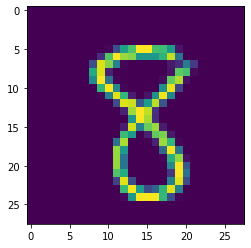

In [9]:
print(y_train[144]) # print the class of the image
plt.imshow(x_train[144]); # print the image
print(x_train[144].shape)

In [10]:
# Define the "feature" layers.  These are the early layers that we expect will "transfer"
# to a new problem.  We will freeze these layers during the fine-tuning process

feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

In [11]:
# Define the "classification" layers.  These are the later layers that predict the specific classes from the features
# learned by the feature layers.  This is the part of the model that needs to be re-trained for a new problem

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes), # The nodes in the last hidden layer must be the same as number of classes
    Activation('softmax')
]

In [12]:
# We create our model by combining the two sets of layers as follows
model = Sequential(feature_layers + classification_layers) # adding the lists to the model

2022-07-30 17:35:18.821575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Let's take a look
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                        

In [14]:
# Now, let's train our model on the digits 5,6,7,8,9

train_model(model,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (29404, 28, 28, 1)
29404 train samples
4861 test samples
Epoch 1/10
230/230 [==============================] - 34s 144ms/step - loss: 1.6037 - accuracy: 0.2138 - val_loss: 1.5838 - val_accuracy: 0.2156
Epoch 2/10
230/230 [==============================] - 34s 147ms/step - loss: 1.5791 - accuracy: 0.2774 - val_loss: 1.5556 - val_accuracy: 0.4053
Epoch 3/10
230/230 [==============================] - 35s 150ms/step - loss: 1.5520 - accuracy: 0.3583 - val_loss: 1.5242 - val_accuracy: 0.5678
Epoch 4/10
230/230 [==============================] - 36s 154ms/step - loss: 1.5222 - accuracy: 0.4318 - val_loss: 1.4885 - val_accuracy: 0.6717
Epoch 5/10
230/230 [==============================] - 35s 152ms/step - loss: 1.4878 - accuracy: 0.4946 - val_loss: 1.4474 - val_accuracy: 0.7221
Epoch 6/10
230/230 [==============================] - 33s 142ms/step - loss: 1.4466 - accuracy: 0.5480 - val_loss: 1.3997 - val_accuracy: 0.7453
Epoch 7/10
230/230 [==============================] - 32s 

### Freezing Layers
Keras allows layers to be "frozen" during the training process.  That is, some layers would have their weights updated during the training process, while others would not.  This is a core part of transfer learning, the ability to train just the last one or several layers.

Note also, that a lot of the training time is spent "back-propagating" the gradients back to the first layer.  Therefore, if we only need to compute the gradients back a small number of layers, the training time is much quicker per iteration.  This is in addition to the savings gained by being able to train on a smaller data set.

In [15]:
# Freeze only the feature layers
for l in feature_layers:
    l.trainable = False

Observe below the differences between the number of *total params*, *trainable params*, and *non-trainable params*.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                        

In [17]:
train_model(model, # same model as before, we will update the last layers only.
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes)

x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Epoch 1/10
240/240 [==============================] - 9s 38ms/step - loss: 1.5384 - accuracy: 0.3494 - val_loss: 1.4687 - val_accuracy: 0.4470
Epoch 2/10
240/240 [==============================] - 9s 37ms/step - loss: 1.4527 - accuracy: 0.4221 - val_loss: 1.3812 - val_accuracy: 0.5234
Epoch 3/10
240/240 [==============================] - 9s 38ms/step - loss: 1.3759 - accuracy: 0.4845 - val_loss: 1.3006 - val_accuracy: 0.5941
Epoch 4/10
240/240 [==============================] - 10s 43ms/step - loss: 1.3078 - accuracy: 0.5424 - val_loss: 1.2261 - val_accuracy: 0.6708
Epoch 5/10
240/240 [==============================] - 10s 41ms/step - loss: 1.2416 - accuracy: 0.6031 - val_loss: 1.1579 - val_accuracy: 0.7369
Epoch 6/10
240/240 [==============================] - 10s 40ms/step - loss: 1.1789 - accuracy: 0.6598 - val_loss: 1.0940 - val_accuracy: 0.7832
Epoch 7/10
240/240 [==============================] - 10s 40ms/step

Note that after a single epoch, we are already achieving results on classifying 0-4 that are comparable to those achieved on 5-9 after 5 full epochs.  This despite the fact the we are only "fine-tuning" the last layer of the network, and all the early layers have never seen what the digits 0-4 look like.

Also, note that even though nearly all (590K/600K) of the *parameters* were trainable, the training time per epoch was still much reduced.  This is because the unfrozen part of the network was very shallow, making backpropagation faster. 

## Exercise
- Now we will write code to reverse this training process.  That is, train on the digits 0-4, then finetune only the last layers on the digits 5-9.

In [18]:
# Create layers and define the model as above
feature_layers2 = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

classification_layers2 = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]
model2 = Sequential(feature_layers2 + classification_layers2)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 activation_4 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_5 (Activation)   (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 32)        0         
                                                      

In [19]:
# Now, let's train our model on the digits 0,1,2,3,4
train_model(model2,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes)

x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Epoch 1/10
240/240 [==============================] - 33s 136ms/step - loss: 1.6055 - accuracy: 0.2443 - val_loss: 1.5765 - val_accuracy: 0.3318
Epoch 2/10
240/240 [==============================] - 33s 137ms/step - loss: 1.5639 - accuracy: 0.3198 - val_loss: 1.5309 - val_accuracy: 0.4094
Epoch 3/10
240/240 [==============================] - 35s 146ms/step - loss: 1.5226 - accuracy: 0.4104 - val_loss: 1.4824 - val_accuracy: 0.6139
Epoch 4/10
240/240 [==============================] - 33s 137ms/step - loss: 1.4753 - accuracy: 0.5068 - val_loss: 1.4288 - val_accuracy: 0.7716
Epoch 5/10
240/240 [==============================] - 33s 136ms/step - loss: 1.4227 - accuracy: 0.5953 - val_loss: 1.3676 - val_accuracy: 0.8469
Epoch 6/10
240/240 [==============================] - 33s 137ms/step - loss: 1.3645 - accuracy: 0.6591 - val_loss: 1.2974 - val_accuracy: 0.8788
Epoch 7/10
240/240 [==============================] - 33s 

In [20]:
#Freeze layers
for l in feature_layers2:
    l.trainable = False

In [21]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 activation_4 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_5 (Activation)   (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 32)        0         
                                                      

In [22]:
train_model(model2,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (29404, 28, 28, 1)
29404 train samples
4861 test samples
Epoch 1/10
230/230 [==============================] - 10s 43ms/step - loss: 1.5942 - accuracy: 0.3014 - val_loss: 1.5286 - val_accuracy: 0.3678
Epoch 2/10
230/230 [==============================] - 10s 42ms/step - loss: 1.5342 - accuracy: 0.3299 - val_loss: 1.4644 - val_accuracy: 0.4116
Epoch 3/10
230/230 [==============================] - 10s 43ms/step - loss: 1.4720 - accuracy: 0.3777 - val_loss: 1.4041 - val_accuracy: 0.4758
Epoch 4/10
230/230 [==============================] - 10s 42ms/step - loss: 1.4200 - accuracy: 0.4237 - val_loss: 1.3469 - val_accuracy: 0.5513
Epoch 5/10
230/230 [==============================] - 10s 42ms/step - loss: 1.3689 - accuracy: 0.4754 - val_loss: 1.2933 - val_accuracy: 0.6137
Epoch 6/10
230/230 [==============================] - 11s 47ms/step - loss: 1.3203 - accuracy: 0.5203 - val_loss: 1.2426 - val_accuracy: 0.6628
Epoch 7/10
230/230 [==============================] - 12s 51ms/s

### Trying a Different Model

In [23]:
# Create layers and define the model as above
feature_layers3 = [
    Conv2D(filters, kernel_size,
           padding='same',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

classification_layers3 = [
    Dense(328),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]
model3 = Sequential(feature_layers3 + classification_layers3)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 activation_8 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 activation_9 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_10 (Activation)  (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)      

In [24]:
train_model(model3,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (29404, 28, 28, 1)
29404 train samples
4861 test samples
Epoch 1/10
230/230 [==============================] - 78s 336ms/step - loss: 1.6058 - accuracy: 0.2369 - val_loss: 1.5994 - val_accuracy: 0.3425
Epoch 2/10
230/230 [==============================] - 78s 340ms/step - loss: 1.5967 - accuracy: 0.2864 - val_loss: 1.5881 - val_accuracy: 0.4962
Epoch 3/10
230/230 [==============================] - 78s 339ms/step - loss: 1.5859 - accuracy: 0.3450 - val_loss: 1.5753 - val_accuracy: 0.6095
Epoch 4/10
230/230 [==============================] - 1874s 8s/step - loss: 1.5731 - accuracy: 0.4018 - val_loss: 1.5600 - val_accuracy: 0.6618
Epoch 5/10
230/230 [==============================] - 119s 519ms/step - loss: 1.5572 - accuracy: 0.4528 - val_loss: 1.5408 - val_accuracy: 0.6892
Epoch 6/10
230/230 [==============================] - 135s 589ms/step - loss: 1.5373 - accuracy: 0.5060 - val_loss: 1.5159 - val_accuracy: 0.7056
Epoch 7/10
230/230 [==============================] - 176

In [25]:
#Freeze layers
for l in feature_layers3:
    l.trainable = False

In [26]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 activation_8 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 activation_9 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_10 (Activation)  (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)      

In [27]:
train_model(model3,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes) # Transfer learning

x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Epoch 1/10
240/240 [==============================] - 30s 122ms/step - loss: 1.5344 - accuracy: 0.3726 - val_loss: 1.4905 - val_accuracy: 0.5057
Epoch 2/10
240/240 [==============================] - 29s 122ms/step - loss: 1.4722 - accuracy: 0.4474 - val_loss: 1.4218 - val_accuracy: 0.5489
Epoch 3/10
240/240 [==============================] - 29s 120ms/step - loss: 1.4097 - accuracy: 0.5120 - val_loss: 1.3557 - val_accuracy: 0.5941
Epoch 4/10
240/240 [==============================] - 39s 164ms/step - loss: 1.3523 - accuracy: 0.5724 - val_loss: 1.2922 - val_accuracy: 0.6951
Epoch 5/10
240/240 [==============================] - 58s 240ms/step - loss: 1.2924 - accuracy: 0.6456 - val_loss: 1.2310 - val_accuracy: 0.7840
Epoch 6/10
240/240 [==============================] - 53s 222ms/step - loss: 1.2373 - accuracy: 0.7060 - val_loss: 1.1727 - val_accuracy: 0.8336
Epoch 7/10
240/240 [==============================] - 51s 

---
### Machine Learning Foundation (C) 2020 IBM Corporation